# Recurrent Neural Network

## Part 0 - Get the data
Currently I use the data provided by Binance, obtained with FIrst Steps (Notebook) function, because I dont like YahooFinancials, but this is the code to download the data from it...

In [100]:
import yfinance as yf #docs at https://pypi.org/project/yfinance/

In [136]:
#get the data
stock = "BTC-USD"
period = "1d" # 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max ( default '1mo')
interval = "5m" # 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo (default '1d')
data = yf.download(tickers=stock, period = period, interval = interval)

[*********************100%***********************]  1 of 1 completed


In [137]:
#save it
data.to_csv("data/yf_"+"_".join([stock,period,interval]))

## Part 1 - Data Preprocessing

### Importing the libraries

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from lib.TechnicalIndicators import *
from pickle import dump

### Importing the training set

In [11]:
#Load data
#stock = "BTC-USD"
#period = "1d" 
#interval = "1m" 
#dataset_location = "../data/yf_"+"_".join([stock,period,interval])
#dataset = pd.read_csv(dataset_location, index_col = "Datetime", parse_dates = ["Datetime"])
filename = "apr2_1h_30k"
dataset = pd.read_csv("data/" + filename +".csv", index_col = "Date", parse_dates = ["Date"])

### Add indicators to dataset 

In [12]:
strategies = [
    SMA(
        data = dataset,
        SMA_S = 5,
        SMA_L = 13,
        column = "Close"
    ),
    EWMA(
        data = dataset,
        approx_avg_period_s = 5,
        approx_avg_period_l = 8,
        column = "Close"
    ),
    BollingerBands(
        data = dataset,
        dev = 1.5, 
        periods = 10,
        column = "Close"
    ),
    MACD(
        data = dataset,
        fast =12,
        slow =26, 
        signal = 9,
        column = "Close"
    ),
    RSI(
        data = dataset,
        length = 14,
        column = "Close"
    ),
    Hammer(
        data = dataset
    ),
    Doji(
        data = dataset
    ),
    EBSW(
        data = dataset,
        column = "Close"
    ),
    ADX(
        data = dataset
    ),
    KVO(
        data = dataset
    ),
    TimeInfo(
        data = dataset
    ),
    ModuleOperator(
        data = dataset, 
        modules = [50, 100, 200, 500, 1000],
        column = "Close"
    )
]
for strategy in strategies:
    strategy.calculate() #add columns to data    

put the desired outcomes, 1, 0 or -1

In [13]:
predict_period = 1 #this is the "n" period after to predict (1 is next period...)
#position can be either -1, 0 or 1
#multiply current close price by factor to prevent losing money with comissions
#dataset["position"] = np.where( dataset["Close"].shift(-predict_period) > dataset["Close"]*(1+predict_bound), 1 , 0)
#dataset["position"] = np.where( dataset["Close"].shift(-predict_period) < dataset["Close"]*(1-predict_bound), -1 , dataset.position)
dataset["position"] = (dataset["Close"].shift(-predict_period) - dataset["Close"])/dataset["Close"]
#drop nas after adding all...
dataset.dropna(inplace = True)
dataset
#store for using in colab (optional)
dataset.to_csv("colab/"+filename+".csv")

split into training and test sets

In [7]:
total_size = dataset.shape[0]
test_size = min(int(total_size*0.2), 1000) #limits max number of test records
train_size = total_size - test_size
dataset_train = dataset.iloc[:train_size]
dataset_test = dataset.iloc[train_size:]
dataset_test

,Open,High,Low,Close,Volume,Quote Asset Volume,Number of Trades,Taker Buy Base Asset Volume,Taker Buy Quote Asset Volume,Close|SMA|7,...,WeekDay,Day,Hour,Minute,mod_Close_50,mod_Close_100,mod_Close_200,mod_Close_500,mod_Close_1000,position
Date,,,,,,,,,,,,,,,,,,,,,
2023-02-20 11:00:00,24589.0,24999.0,24532.2,24881.5,8505.134,2.114789e+08,3787,4670.486,1.162279e+08,24615.071429,...,0,20,11,0,31.5,81.5,81.5,381.5,881.5,-0.002472
2023-02-20 12:00:00,24862.0,24998.0,24620.0,24820.0,10119.419,2.511337e+08,3722,5050.781,1.254146e+08,24662.400000,...,0,20,12,0,20.0,20.0,20.0,320.0,820.0,0.000898
2023-02-20 13:00:00,24805.0,24999.0,24754.3,24842.3,5854.554,1.455280e+08,2426,2964.730,7.371579e+07,24710.185714,...,0,20,13,0,42.3,42.3,42.3,342.3,842.3,0.005595
2023-02-20 14:00:00,24968.0,25239.0,24620.0,24981.3,11208.827,2.791130e+08,4254,5743.338,1.431414e+08,24777.628571,...,0,20,14,0,31.3,81.3,181.3,481.3,981.3,-0.001097
2023-02-20 15:00:00,24981.3,25213.8,24695.0,24953.9,8293.993,2.069644e+08,3580,3871.890,9.667276e+07,24849.114286,...,0,20,15,0,3.9,53.9,153.9,453.9,953.9,-0.003298
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-02 22:00:00,28021.0,28225.0,27886.0,28150.0,5724.757,1.603523e+08,5483,2975.140,8.342538e+07,28092.685714,...,6,2,22,0,0.0,50.0,150.0,150.0,150.0,0.001702
2023-04-02 23:00:00,28150.0,28350.0,28068.4,28197.9,5663.442,1.597356e+08,4488,2918.842,8.246372e+07,28104.400000,...,6,2,23,0,47.9,97.9,197.9,197.9,197.9,-0.000713
2023-04-03 00:00:00,28171.8,28350.0,28065.3,28177.8,4036.373,1.136892e+08,3223,2410.271,6.794765e+07,28104.500000,...,0,3,0,0,27.8,77.8,177.8,177.8,177.8,-0.008766


cols to use (the predicted one is "position")

In [8]:
#cols = ["Open", "Volume"]
#cols = dataset_train.columns #use all
#training_set = dataset_train[cols].loc[:].values
training_set = dataset_train.drop(["position"], axis=1)
training_set

,Open,High,Low,Close,Volume,Quote Asset Volume,Number of Trades,Taker Buy Base Asset Volume,Taker Buy Quote Asset Volume,Close|SMA|7,...,CDL_GRAVESTONEDOJI,WeekDay,Day,Hour,Minute,mod_Close_50,mod_Close_100,mod_Close_200,mod_Close_500,mod_Close_1000
Date,,,,,,,,,,,,,,,,,,,,,
2019-11-01 13:00:00,9187.73,9218.83,9073.09,9113.00,200023.852,1.825556e+09,6697,123982.772,1.131322e+09,9138.287143,...,0.0,4,1,13,0,13.00,13.00,113.00,113.00,113.00
2019-11-01 14:00:00,9112.81,9132.82,9075.82,9123.69,188408.213,1.715961e+09,6339,109385.517,9.962379e+08,9141.812857,...,0.0,4,1,14,0,23.69,23.69,123.69,123.69,123.69
2019-11-01 15:00:00,9122.74,9245.00,9084.20,9090.30,192426.801,1.757535e+09,6579,117199.537,1.070602e+09,9134.985714,...,0.0,4,1,15,0,40.30,90.30,90.30,90.30,90.30
2019-11-01 16:00:00,9083.12,9186.83,9071.72,9154.19,195383.163,1.782788e+09,6577,121342.613,1.107178e+09,9142.115714,...,0.0,4,1,16,0,4.19,54.19,154.19,154.19,154.19
2019-11-01 17:00:00,9150.59,9200.02,9138.23,9157.66,188500.905,1.727507e+09,6337,114832.325,1.052376e+09,9141.590000,...,0.0,4,1,17,0,7.66,57.66,157.66,157.66,157.66
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-20 06:00:00,24498.30,24800.00,24423.90,24507.80,5733.833,1.404048e+08,1741,2957.445,7.244530e+07,24385.542857,...,0.0,0,20,6,0,7.80,7.80,107.80,7.80,507.80
2023-02-20 07:00:00,24504.00,24800.00,24400.00,24509.20,7596.053,1.861304e+08,2177,4032.486,9.883630e+07,24427.814286,...,0.0,0,20,7,0,9.20,9.20,109.20,9.20,509.20
2023-02-20 08:00:00,24506.00,24830.00,24290.00,24453.50,7603.985,1.861793e+08,2415,3824.433,9.366654e+07,24457.471429,...,0.0,0,20,8,0,3.50,53.50,53.50,453.50,453.50


### Feature Scaling

In [9]:
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
#feature_range = (-1, 1)
#frs = "".join(map(str, feature_range))
#sc = MinMaxScaler(feature_range = feature_range)
quantile_range = (25,75)
frs = "".join(map(str, quantile_range))
sc = RobustScaler(quantile_range=quantile_range) #this removes median and scales by quantile_range
#sc = StandardScaler()
#frs = "ss"
training_set_scaled = sc.fit_transform(training_set)
dump(sc, open('models/scaler'+ frs +'_' + filename + '.pkl', 'wb'))
#pd.DataFrame(training_set_scaled, columns = training_set.columns).describe()

### Creating a data structure with "n" timesteps and 1 output

In [24]:
timestamps = 12
X_train = []
y_train = []
for i in range(timestamps, train_size+1): #use all available datset (+1 because one method dont include upper bound)
    #X_train.append(training_set_scaled[i-timestamps:i]) #doesnt include upper bound
    y_train.append(dataset_train["position"][i-1]) #predict position corresponding of last row input
X_train, y_train = np.array(X_train), np.array(y_train)
#print(X_train) 
#print(y_train[-1])
#print(X_train.shape)
#print(y_train.shape)

In [25]:
inputs = dataset[len(dataset) - len(dataset_test) - timestamps+1:].drop(["position"], axis=1)
inputs = sc.transform(inputs)
X_test = []
for i in range(timestamps, len(inputs)+1):
    X_test.append(inputs[i-timestamps:i])
X_test = np.array(X_test)
real_position = dataset_test["position"].values

### Reshaping

In [31]:
#X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

## Part 2 - Building and Training the RNN

### Importing the Keras libraries and packages

In [7]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import tensorflow as tf
import keras
#https://towardsdatascience.com/how-to-choose-the-right-activation-function-for-neural-networks-3941ff0e6f9c

### Initialising the RNN

In [16]:
model = Sequential()

# Adding LSTM layers with some Dropout regularisation
model.add(LSTM(units = 15, return_sequences = True, activation = "tanh", 
                   input_shape = (X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.3))

model.add(LSTM(units = 15,  activation = "tanh"))
model.add(Dropout(0.3))

#output layer
model.add(Dense(units = 1, activation ="tanh"))

2022-12-21 18:57:39.012653: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-12-21 18:57:39.014959: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-21 18:57:39.017415: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (mauricio-SVF14423CLW): /proc/driver/nvidia/version does not exist
2022-12-21 18:57:39.037237: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Compiling the RNN

In [17]:
#Optimizers
adam = tf.keras.optimizers.Adam(learning_rate=1e-03)
#Losses
cs = tf.keras.losses.CosineSimilarity(axis=-1, reduction="auto", name="cosine_similarity")
msle =  tf.keras.losses.MeanSquaredLogarithmicError( reduction="auto", name="mean_squared_logarithmic_error")
#Compile
model.compile(optimizer = adam,loss = "mean_squared_error")

### Fitting the RNN to the Training set

In [ ]:
# This callback will stop the training when there is no improvement in
# the loss for three consecutive epochs.
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
history = model.fit(X_train, y_train, epochs = 200, batch_size = 128, validation_data =(X_test, real_position),
                   callbacks=[callback])

2022-12-21 18:58:02.245495: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 783105840 exceeds 10% of free system memory.


Epoch 1/200
121/773 [===>..........................] - ETA: 1:52 - loss: 0.1686

In [55]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 36, 15)            2940      
                                                                 
 dropout (Dropout)           (None, 36, 15)            0         
                                                                 
 lstm_1 (LSTM)               (None, 15)                1860      
                                                                 
 dropout_1 (Dropout)         (None, 15)                0         
                                                                 
 dense (Dense)               (None, 1)                 16        
                                                                 
Total params: 4,816
Trainable params: 4,816
Non-trainable params: 0
_________________________________________________________________


In [38]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
#plt.plot(history.history['accuracy'])
#plt.plot(history.history['val_accuracy'])
#plt.title('model accuracy')
#plt.ylabel('accuracy')
#plt.xlabel('epoch')
#plt.legend(['train', 'test'], loc='upper left')
#plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

NameError: name 'history' is not defined

In [27]:
#model.save('models/rnn_15_'+ filename + "_" + str(timestamps)+ "_" + "_" + frs + '.h5')
#load model
model = keras.models.load_model('models/rnn_512_dic21_5m_12_0.004_-11.h5')

## Part 3 - Making the predictions and visualising the results

### Getting the predicted stock price

In [28]:
predicted_position = model.predict(X_test)
print(predicted_position)
print(inputs.shape)
print(X_test.shape)

ValueError: in user code:

    File "/home/mauricio/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 2041, in predict_function  *
        return step_function(self, iterator)
    File "/home/mauricio/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 2027, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/mauricio/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 2015, in run_step  **
        outputs = model.predict_step(data)
    File "/home/mauricio/anaconda3/lib/python3.9/site-packages/keras/engine/training.py", line 1983, in predict_step
        return self(x, training=False)
    File "/home/mauricio/anaconda3/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/mauricio/anaconda3/lib/python3.9/site-packages/keras/engine/input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential" is incompatible with the layer: expected shape=(None, 12, 33), found shape=(None, 12, 32)


[ 0  1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0
  0  0  1  0  0  0  0  0  0  0  0  1  0  0  0  0 -1  1  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  1 -1  1 -1  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1 -1
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1 -1  0
  0  0  0  0  0  1 -1  0  0  1  0  0  0 -1  0  0  0  0  0  0  0  0  0  0
  1 -1  1 -1  0  0  0  1 -1  0  0  0  1 -1  0  0  0  0  1  0 -1  1 -1  0
  0  0  1  0 -1  1 -1  0  0  1 -1  1 -1  1 -1  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  1 -1  0  0  1 -1  0  0  0  0  0  0 -1  1  0  0  0
  0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0

### Visualising the results

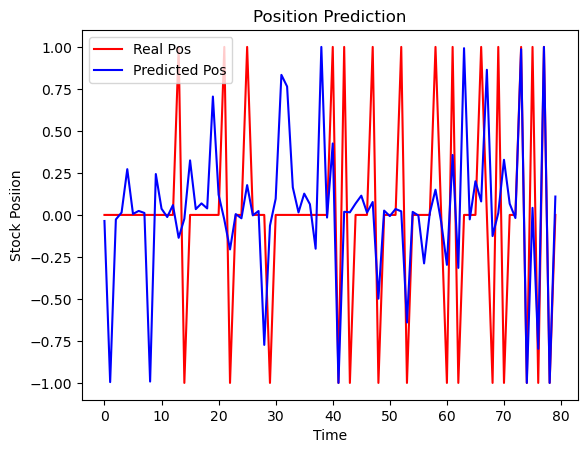

In [40]:
plt.plot(real_position[200:280], color = 'red', label = 'Real Pos')
plt.plot(predicted_position[200:280], color = 'blue', label = 'Predicted Pos')
plt.title('Position Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Posiion')
plt.legend()
plt.show()

In [43]:
limit = 0.005
pred_pos = [0]* len(real_position)
real_pos = [0]* len(real_position)
predicted_position = predicted_position.flatten()
pred_pos = np.where( predicted_position  > limit, 1 , pred_pos)
pred_pos = np.where( predicted_position  < -limit, -1 , pred_pos)
real_pos = np.where( real_position  > limit, 1 , real_pos)
real_pos = np.where( real_position  < -limit, -1 , real_pos)
#np.unique(pred_pos)
#np.count_nonzero(pred_pos == -1)
results = pred_pos * real_pos
hits = np.count_nonzero(results==1) #good positions
print("hits = {}".format(hits)) 
print("percentage of hits {}%".format(  hits/len(real_position)*100  ))
print("--------------------------")
good_long_trades = np.where( np.logical_and(pred_pos * real_pos == 1, pred_pos > 0), 1 , 0)
good_short_trades = np.where( np.logical_and(pred_pos * real_pos == 1, pred_pos < 0), 1 , 0)
print("good long positions = {}".format(np.sum(good_long_trades))) 
print("good short positions = {}".format(np.sum(good_short_trades))) 

bad_long_trades = np.where( np.logical_and(pred_pos * real_pos == -1, pred_pos > 0), 1 , 0)
bad_short_trades = np.where( np.logical_and(pred_pos * real_pos == -1, pred_pos < 0), 1 , 0)
print("bad long positions = {}".format(np.sum(bad_long_trades))) 
print("bad short positions = {}".format(np.sum(bad_short_trades))) 

false_long_trades = np.where( np.logical_and(pred_pos  > 0, real_pos == 0), 1 , 0)
false_short_trades = np.where( np.logical_and(pred_pos  < 0, real_pos == 0), 1 , 0)
print("false long positions = {}".format(np.sum(false_long_trades))) 
print("false short positions = {}".format(np.sum(false_short_trades))) 

total_good_positions = np.sum(good_long_trades) + np.sum(good_short_trades)
total_positions =  np.sum(np.where( pred_pos  != 0, 1 , 0))
print("--------------------------")
print("total good positions are {}".format(total_good_positions))
print("total positions made are {}".format(total_positions))
print("accuracy of positions made is {}%".format(  round(total_good_positions/total_positions,3)*100 ))

false_negative = np.sum(np.where( np.logical_and(pred_pos  == 0, real_pos != 0), 1 , 0))
print("total false neutral positions are {}({}% of total period)".format(false_negative, round(false_negative/len(real_position)*100, 3)))


hits = 916
percentage of hits 91.60000000000001%
--------------------------
good long positions = 2
good short positions = 5
bad long positions = 1
bad short positions = 0
false long positions = 12
false short positions = 13
--------------------------
total good positions are 7
total positions made are 33
accuracy of positions made is 21.2%
total false neutral positions are 58(5.8% of total period)


In [13]:
dataset.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Quote Asset Volume',
       'Number of Trades', 'Taker Buy Base Asset Volume',
       'Taker Buy Quote Asset Volume', 'Close|SMA|5', 'Close|SMA|13',
       'Close|EWMA|a5', 'Close|EWMA|a8', 'Close|SMA|10',
       'Close|BBs|1.5|10|Lower', 'Close|BBs|1.5|10|Upper',
       'Close|BBs|1.5|10|Distance', 'Close_MACD_12_26_9',
       'Close_MACDh_12_26_9', 'Close_MACDs_12_26_9', 'Close_RSI_14',
       'CDL_HAMMER', 'CDL_INVERTEDHAMMER', 'CDL_DOJI_10_0.1',
       'CDL_DRAGONFLYDOJI', 'CDL_GRAVESTONEDOJI', 'Close_EBSW',
       'Close_High_Low_ADX_14', 'Close_High_Low_DMP_14',
       'Close_High_Low_DMN_14', 'Close_High_Low_Volume_KVO_34_55_13',
       'Close_High_Low_Volume_KVOs_34_55_13', 'WeekDay', 'Day', 'Hour',
       'Minute', 'mod_Close_50', 'mod_Close_100', 'mod_Close_200',
       'mod_Close_500', 'mod_Close_1000', 'position'],
      dtype='object')

In [70]:
dataset[["High", "Open"]]

,High,Open
Date,,
2022-10-31 17:44:00,20644.9,20644.9
2022-10-31 17:45:00,20644.9,20640.0
2022-10-31 17:46:00,20644.9,20641.2
2022-10-31 17:47:00,20644.9,20640.0
2022-10-31 17:48:00,20644.9,20512.0
...,...,...
2022-12-19 07:12:00,16789.0,16787.0
2022-12-19 07:13:00,16789.0,16789.0
2022-12-19 07:14:00,16790.0,16789.0


### Results

Files RNNs:

N   | Name   | New                                       |
--- | ---    | ---                                       |
1   |  1.h5  | -                                         |
2   |  2.h5  | 0.2 Dropout, 24 Timestamps                |
3   |  -     | Used CosineSimilarity loss. BAD RESULTS   |
4   |  -     | Used MSLE loss. BAD RESULTS               |
5   |  5.h5  | 36 timestamps                             |
6   |  6.h5  | 24 timestamps, added TimeInfo             |
7   |  7.h5  | Added ModuleOperator                      |
8   |  8.h5  | Continue traning 7, Adam LR is now 1e-04  |
9   |  9.h5  | Continue traning 6, Adam LR is now 1e-04  |
10  |  10.h5 | Same as 7, but 1024 (2x of 7) neurons. Obtained same results.             |
11  |  11.h5 | Same as 7, but 128 (1/4 of 7) neurons. Obtained Better results.            |
12  |  12.h5 | Same as 7, but 32 (1/16 of 7) neurons. Obtained Better results          |
13  |  13.h5 | Same as 7, but 4 (1/128 of 7) neurons. Obtained Better results          |
14  |  14.h5 | Same as 7, but 1 neurons. Obtained Better results          |
15  |  15.h5 | Same as 14, but 12 timestamps (half)        |
16  |  16.h5 | Two layers of LSTM 12-12        |
17  |  17.h5 | Same as 16 but with 12-12-12. Same Result        |
18  |  18.h5 | Same as 16 but with 24-24-24. Overfitted?        |
19  |  18.h5 | Same as 18 but with tmps 24 (2x). Overfitted?        |
20  |  18.h5 | Less strategies, tmps 36, added EarlyStopping(val_loss). Neurons 64-32-16. StandardScaler  |
21  |  18.h5 |  Used larger dataset and more strategies than (20). Tmps 24. Poor results on both datasets (loss train  6.4706e-05).  |
22  |  18.h5 | Same as 21 but with neurons 24-24-24, same result as 21      |


Datasets:

N   | Dataset (test)        | Pred. Per. | Scaler      |
--- | ---                   | ---        | ---         |
1   | dic24_5m_30k.csv (1k) | 1          | R(25,75)    |
2   | dic24_5m_30k.csv (1k) | 1          | R(25,75)    |
5   | dic24_5m_30k.csv (1k) | 1          | R(25,75)    |
6   | dic24_5m_30k.csv (1k) | 1          | R(25,75)    |
7   | dic24_5m_30k.csv (1k) | 1          | R(25,75)    |
8   | dic24_5m_30k.csv (1k) | 1          | R(25,75)    |
9   | dic24_5m_30k.csv (1k) | 1          | R(25,75)    |
11  | dic24_5m_30k.csv (1k) | 1          | R(25,75)    |
12  | dic24_5m_30k.csv (1k) | 1          | R(25,75)    |
13  | dic24_5m_30k.csv (1k) | 1          | R(25,75)    |
14  | dic24_5m_30k.csv (1k) | 1          | R(25,75)    |
15  | dic24_5m_30k.csv (1k) | 1          | R(25,75)    |
16  | dic24_5m_30k.csv (1k) | 1          | R(25,75)    |
18  | dic24_5m_30k.csv (1k) | 1          | R(25,75)    |
19  | dic24_5m_30k.csv (1k) | 1          | R(25,75)    |
20  | dic24_5m_30k.csv (1k) | 1          | SS          |
21  | dic21_5m_100k.csv (5k)| 1          | SS          |

Descriptions:

N  | Neurons  | dropout | Tmps | epcs(tol) | batch | Optimizer   | Loss (train:test)           | 
---|  ---     | ---     | ---  | ---       | ---   | ---         | ---                         |
1  | 512      | 0.4     | 12   | 22(3)     | 256   | Adam(1e-03) | MSE (ke-05:IDK)             |
2  | 512      | 0.2     | 24   | 50(7)     | 256   | Adam(1e-03) | MSE (3.0105e-05:3.8450e-06) |
5  | 512      | 0.2     | 36   | 41(7)     | 256   | Adam(1e-03) | MSE (3.1e-05:6.35e-06)      |
6  | 512      | 0.2     | 24   | 39(7)     | 256   | Adam(1e-03) | MSE (3.2410e-05:3.5258e-06) |
7  | 512      | 0.2     | 24   | ~67 (7)   | 256   | Adam(1e-03) | MSE (3.0450e-05:2.3933e-05) |
8  | 512      | 0.2     | 24   | 17(7)     | 256   | Adam(1e-04) | MSE (2.6139e-05:3.7108e-06) |
9  | 512      | 0.2     | 24   | 35(7)     | 256   | Adam(1e-04) | MSE (2.6936e-05:4.5735e-06) |
11 | 128      | 0.2     | 24   | 72(7)     | 256   | Adam(1e-03) | MSE (2.9571e-05:4.5059e-06) |
12 | 32       | 0.2     | 24   | 125(7)    | 256   | Adam(1e-03) | MSE (2.5647e-05:3.6284e-06) |
13 | 4        | 0.2     | 24   | 162(7)    | 256   | Adam(1e-03) | MSE (2.8310e-05:3.9064e-06) |
14 | 1        | 0.2     | 24   | 165(7)    | 256   | Adam(1e-03) | MSE (2.9755e-05:3.4479e-06) |
15 | 1        | 0.2     | 12   | 160(15)   | 256   | Adam(1e-03) | MSE (3.0011e-05:3.6654e-06) |
16 | 12:12:12 | 0.2     | 12   | 212(15)   | 256   | Adam(1e-03) | MSE (2.4335e-05:3.7486e-06) |
18 | 12:12:12 | 0.2     | 12   | 309(15)   | 256   | Adam(1e-03) | MSE (1.8328e-05:5.0477e-06) |
19 | 24:24:24 | 0.2     | 24   | 443(15)   | 256   | Adam(1e-03) | MSE (1.6253e-05:5.4.0151e-06) |
20 | 64:32:16 | 0.2     | 36   | 85(15)   | 256   | Adam(1e-03) | MSE (2.9224e-05:4.2414e-06) |
21 | 64:32:16 | 0.2     | 24   | (15)   | 256   | Adam(1e-03) | MSE () |
 
accuracy of positions made:

N  | 0.001 | 0.002 | 0.003 | 0.004 | 0.005 |
---| ---   | ---   | ---   | ---   | ---   |
1  | 15%   | 12.8% | 21.9% | 37.1% | 59.59%|
2  | 35.09%| 53.8% | 57.9% | 66.7% | 58.3% |
5  | 18.8% | 28.1% | 46.0% | 50.8% | 64.0% |
6  | 44.1% | 63.2% | 62.1% | 50%   | 0%    |
7  | 14.49%| 10.9% | 8%    | 6.4%  | 7.5%  |
8  | 39%   | 46.3% | 49.3% | 53.1% | 42.9% |
9  | 27.4% | 31%   | 40%   | 62%   | 50%   |
11 | 27.4% | 45.8% | 55.6% | 63.6% | 61.1% |
12 | 39.2% | 56.49%| 62.3% | 58.3% | 61.5% |
13 | 31.7% | 47.59%| 51.6% | 47.09%| 33.3% |
14 | 54%   | 59.4% | 50%   | 50%   | 50%   |
15 | 54.1% | 64.1% | 69.69%| 71.39%| 77.8% |
16 | 41.8% | 51.4% | 50%   | 57.09%| 60%   |
18 | 31.1% | 37.6% | 42%   | 47.8% | 46.7% |
19 | 47.19%| 53.6% | 51.9% | 45.5% | 45% |
20 | 45%| 44.4% | 66.7% | 50% | - |
21|| %| % | % | % | % |


strategies: 

1,2,3,4,5:
[
    SMA(
        data = dataset,
        SMA_S = 5,
        SMA_L = 13,
        column = "Close"
    ),
    EWMA(
        data = dataset,
        approx_avg_period_s = 5,
        approx_avg_period_l = 8,
        column = "Close"
    ),
    BollingerBands(
        data = dataset,
        dev = 1.5, 
        periods = 10,
        column = "Close"
    ),
    MACD(
        data = dataset,
        fast =12,
        slow =26, 
        signal = 9,
        column = "Close"
    ),
    RSI(
        data = dataset,
        length = 14,
        column = "Close"
    ),
    Hammer(
        data = dataset
    ),
    Doji(
        data = dataset
    ),
    EBSW(
        data = dataset,
        column = "Close"
    ),
    ADX(
        data = dataset
    ),
    KVO(
        data = dataset
    )
]

6,9:  [
    SMA(
        data = dataset,
        SMA_S = 5,
        SMA_L = 13,
        column = "Close"
    ),
    EWMA(
        data = dataset,
        approx_avg_period_s = 5,
        approx_avg_period_l = 8,
        column = "Close"
    ),
    BollingerBands(
        data = dataset,
        dev = 1.5, 
        periods = 10,
        column = "Close"
    ),
    MACD(
        data = dataset,
        fast =12,
        slow =26, 
        signal = 9,
        column = "Close"
    ),
    RSI(
        data = dataset,
        length = 14,
        column = "Close"
    ),
    Hammer(
        data = dataset
    ),
    Doji(
        data = dataset
    ),
    EBSW(
        data = dataset,
        column = "Close"
    ),
    ADX(
        data = dataset
    ),
    KVO(
        data = dataset
    ),
    TimeInfo(
        data = dataset
    )
]

7,8,10,11, 12, 13, 14, 15,16, 17, 18, 21: [
    SMA(
        data = dataset,
        SMA_S = 5,
        SMA_L = 13,
        column = "Close"
    ),
    EWMA(
        data = dataset,
        approx_avg_period_s = 5,
        approx_avg_period_l = 8,
        column = "Close"
    ),
    BollingerBands(
        data = dataset,
        dev = 1.5, 
        periods = 10,
        column = "Close"
    ),
    MACD(
        data = dataset,
        fast =12,
        slow =26, 
        signal = 9,
        column = "Close"
    ),
    RSI(
        data = dataset,
        length = 14,
        column = "Close"
    ),
    Hammer(
        data = dataset
    ),
    Doji(
        data = dataset
    ),
    EBSW(
        data = dataset,
        column = "Close"
    ),
    ADX(
        data = dataset
    ),
    KVO(
        data = dataset
    ),
    TimeInfo(
        data = dataset
    ),
    ModuleOperator(
        data = dataset, 
        modules = [50, 100, 200, 500, 1000],
        column = "Close"
    )
]

20: [
    SMA(
        data = dataset,
        SMA_S = 5,
        SMA_L = 8,
        column = "Close"
    ),
    SMA(
        data = dataset,
        SMA_S = 5,
        SMA_L = 13,
        column = "Close"
    ),
    EWMA(
        data = dataset,
        approx_avg_period_s = 5,
        approx_avg_period_l = 8,
        column = "Close"
    ),
    EWMA(
        data = dataset,
        approx_avg_period_s = 5,
        approx_avg_period_l = 13,
        column = "Close"
    ),
    BollingerBands(
        data = dataset,
        dev = 1.5, 
        periods = 10,
        column = "Close"
    ),
    MACD(
        data = dataset,
        fast =12,
        slow =26, 
        signal = 9,
        column = "Close"
    ),
    RSI(
        data = dataset,
        length = 14,
        column = "Close"
    ),
    TimeInfo(
        data = dataset
    ),
    ModuleOperator(
        data = dataset, 
        modules = [50, 100, 200, 500, 1000],
        column = "Close"
    )
]

22: strategies = [
    SMA(
        data = dataset,
        SMA_S = 5,
        SMA_L = 13,
        column = "Close"
    ),
    EWMA(
        data = dataset,
        approx_avg_period_s = 5,
        approx_avg_period_l = 8,
        column = "Close"
    ),
    BollingerBands(
        data = dataset,
        dev = 1.5, 
        periods = 10,
        column = "Close"
    ),
    MACD(
        data = dataset,
        fast =12,
        slow =26, 
        signal = 9,
        column = "Close"
    ),
    RSI(
        data = dataset,
        length = 14,
        column = "Close"
    ),
    Hammer(
        data = dataset
    ),
    Doji(
        data = dataset
    ),
    EBSW(
        data = dataset,
        column = "Close"
    ),
    ADX(
        data = dataset
    ),
    KVO(
        data = dataset
    ),
    TimeInfo(
        data = dataset
    ),
    ModuleOperator(
        data = dataset, 
        modules = [50, 100, 200, 500, 1000],
        column = "Close"
    )
]

### Ideas

Dont know if I should use Feature range (0,1) or (-1, 1)

predict_bound may be less? I have to consider the leverage I will use.

StandardScaler, MinMaxScaler and RobustScaler: use robust scaler before to remove outliers of data.

Test rnn with just one layer and more neurons (recommended from a page if from 512 to 2560)

I have been using dataset of 100k records, should I use more? Should I use a different number from diferent intervals (1m, 5m, etc.)?

It is better to use a bigger interval for predicions (result 5m > result 1m)?

Im using batch size 128 (recommended is from 32 to 128).

Im using mean squared error for loss

Im using 1e-3 for adam learning rate

Change strategies used for rnn

using dropout but maybe could be other thing to optimize learning...

Currently training on 200 epochs, often at the 100th it wont improve much... i dont know if need more...

compute loss of test set to compare with train...

Should I remove OBV of indicators for rnn? 

Should I use less most-recent data? like last 2 months only

## Last work

I removed OBV but forgot to download the rnn, so i will also add robustscaler and maybe train with most recent info. to train a new one